# Prediction of learning time with a Random Forest Classifier 
Dec2020
@author:Ines
@editor:Ines

Training time is predicted using a Random Forest Classifier. In particular, the quartiles of the training time distribution (in sessions) are predicted.
These quartiles are computed after exclusion of mice due to missing data.
All mice are used in the model, without equalization of number of animals per quartile (NQ1=27, NQ2=28, NQ3=27, NQ4=26).
The model is run once and a shuffled model is run 100 times with random shuffles each time.
Feature importances are calculated by permuting each feature and evaluating the corresponding drop in the model's accuracy (F1 score); this is done several times for each feature and without cross-validation.

In [2]:
"""
IMPORTS
"""
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from scipy import stats

# --Get my functions
from random_forest_functions import query_subjects, training_trials, design_matrix

Connecting ines.laranjeira@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as ines


In [3]:
"""
QUERY DATA WITH DATAJOINT
"""

subjects = query_subjects(as_dataframe=False, criterion='trained')
trials = training_trials(subjects)  # Gets all trials for all mice for first 5 sessions, hard-coded

In [4]:
"""
DESIGN MATRIX
"""
matrix = design_matrix(trials, subjects, session=5) 

/anaconda3/envs/iblenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/anaconda3/envs/iblenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/anaconda3/envs/iblenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/anaconda3/envs/iblenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/anaconda3/envs/iblenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/anaconda3/envs/iblenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/anaconda3/envs/iblenv/lib/python3.7/sit

Mouse 1627878b-0863-4241-9396-43f89d6d70af missing starting weight
Mouse 1627878b-0863-4241-9396-43f89d6d70af missing data
Mouse 18a54f60-534b-4ed5-8bda-b434079b8ab8 missing starting weight
Mouse 18a54f60-534b-4ed5-8bda-b434079b8ab8 missing data
Mouse 354e6122-de4a-4945-bafd-d46df65768f6 missing starting weight
Mouse 354e6122-de4a-4945-bafd-d46df65768f6 missing data
Mouse 726e6b19-e9ef-4e37-a7d7-986d5bcd551c missing data
Mouse 7d334e82-1270-4346-86c2-4a8b7530946d missing data
Mouse 94aca514-aeed-4189-8123-24099bb03452 missing starting weight
Mouse 94aca514-aeed-4189-8123-24099bb03452 missing data
Mouse 95241a9c-481b-443c-83a7-462165f729ec missing starting weight
Mouse 95241a9c-481b-443c-83a7-462165f729ec missing data
Mouse 9a46fcfa-81cf-4742-87c0-bb95f90d5913 missing starting weight
Mouse 9a46fcfa-81cf-4742-87c0-bb95f90d5913 missing data
Mouse 9b471b07-5903-4baa-b56d-368d385c850c missing starting weight
Mouse 9b471b07-5903-4baa-b56d-368d385c850c missing data
Mouse c00e0ffb-b8c6-4953-b9

In [6]:
"""
PROCESS DESIGN MATRIX
"""

mat = matrix.copy()
var = 'new_quantile'

mat = mat.dropna()
mat = mat.drop_duplicates()
mat['new_quantile'] = mat['training_time']
crit = mat['training_time'].dropna()
quantiles = crit.quantile([.25, .5, .75])
mat.loc[mat['training_time'] <= quantiles[0.25], 'new_quantile'] = 1
mat.loc[(mat['training_time'] > quantiles[0.25]) & (mat['training_time'] <= quantiles[0.5]), 'new_quantile'] = 2
mat.loc[(mat['training_time'] > quantiles[0.5]) & (mat['training_time'] <= quantiles[0.75]), 'new_quantile'] = 3
mat.loc[mat['training_time'] > quantiles[0.75], 'new_quantile'] = 4

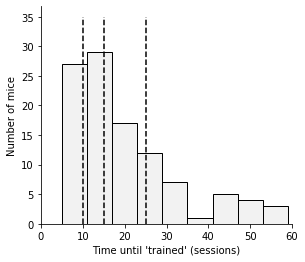

In [7]:
"""
HISTOGRAM - include all mice used to calculate quartiles
"""

plt.figure(figsize=[4.5, 4])
plt.xlabel("Time until 'trained' (sessions)")
plt.ylabel("Number of mice")
plt.xlim([0,60])
plt.rc('font', size=12)
sns.despine(top=True, right=True)
points = sns.histplot(list(mat['training_time'].dropna()), kde=False, color='black', edgecolor='k', alpha=0.05, linewidth=1) 
plt.vlines(quantiles[0.25], 0, 30, colors='k', linestyles='dashed')
plt.vlines(quantiles[0.5], 0, 30, colors='k', linestyles='dashed')
plt.vlines(quantiles[0.75], 0, 30, colors='k', linestyles='dashed')

In [8]:
# --Remove NaNs and mouse column from design matrix

mat = mat.drop(columns=['subject_nickname', 'subject_uuid', 'training_time', 'quantile'])
mat1 = mat.copy() # Full classifier
mat2 = mat1[['perf_delta1', var]] # Performance change classifier; get matrix from mat1, to make sure the same mice are included

In [12]:
"""
RUN MODEL - no downsampling - works well - DONT TOUCH
"""

# Generate random states for each iteration with a fixed seed
# Loop over iterations of random draws of mice

shufflings = 100  #shuffling
repetitions = 10  # permutation repetitions
model = RandomForestClassifier(random_state=0)
matrices = [mat1, mat2]

# Create empty dataframes to save results
decoding_result = pd.DataFrame(columns=['matrix', 'shuffle', 'f1', 'confusion_matrix'])

for m, mt in enumerate(matrices):

    # Decoding function with 10-fold cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    use_mat = matrices[m].copy() # test using all mice

    # -- ORIGINAL DATASET
    
    dec_result = pd.DataFrame(columns=['matrix', 'shuffle', 'f1', 'confusion_matrix'])

    y_pred = np.zeros(len(use_mat), dtype=int) 
    exog = use_mat[use_mat.columns.difference([var])]
    endog = use_mat.loc[:, var]

    for train_index, test_index in kf.split(use_mat):
        model.fit(exog.iloc[train_index], endog.iloc[train_index].astype(int))
        y_pred[test_index] = model.predict(exog.iloc[test_index])

    # Calculate f1 score and confusion matrix
    f1 = f1_score(endog.astype(int), y_pred.astype('int'), average='micro')
    cm = confusion_matrix(endog.astype(int), y_pred.astype('int'), normalize='true')
    
    # Save results
    dec_result.loc[0, 'f1'] = f1
    dec_result.loc[0, 'confusion_matrix'] = cm
    dec_result.loc[0, 'matrix'] = m
    dec_result.loc[0, 'shuffle'] = 0

    decoding_result = pd.concat([decoding_result, dec_result])
    
    # -- DETERMINE FEATURE IMPORTANCE BY PERMUTING FEATURE VALUES
    
    
    # Only for the full model 
    if m == 0:
        features = exog.keys() 
        permutation_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
            
        # Score of original non-cross-validated model    
        original_model = model.fit(exog, endog.astype(int))
        original_pred = np.zeros(len(exog), dtype=int) 
        original_pred = model.predict(exog)
        original_f1 = f1_score(endog.astype(int), original_pred.astype('int'), average='micro')

        # Loop over each feature 
        for f, feature in enumerate(features):
            print('Permuting %s' % (features[f]))  
        
            # Permute each feature several times
            perm_result = pd.DataFrame(columns=['repetition', 'feature', 'f1'])
            for n in range(repetitions):
            
                permuted_exog = exog.copy()
                permuted_exog[features[f]] = np.random.permutation(permuted_exog[features[f]].values)
                
                #  Fit model and make predictions
                model.fit(exog, endog.astype(int))
                permuted_y_pred = np.zeros(len(exog), dtype=int)
                permuted_y_pred = model.predict(permuted_exog)
                
                # Calculate f1 score for model with permuted feature
                permuted_f1 = f1_score(endog.astype(int), permuted_y_pred.astype('int'), average='micro')

                # Save results
                perm_result.loc[n, 'repetition'] = n
                perm_result.loc[n, 'feature'] = features[f]
                perm_result.loc[n, 'f1'] = permuted_f1
            
            permutation_result = pd.concat([permutation_result, perm_result])
    
    # -- SHUFFLED DATASET 

    shuffle_result = pd.DataFrame(columns=['matrix', 'shuffle', 'f1', 'confusion_matrix'])

    for s in range(shufflings):
        if np.mod(s+1, 10) == 0:
            print('Shuffling %d of %d' % (s+1, shufflings))   

        shuffle_y_pred = np.zeros(len(use_mat), dtype=int) 
        shuffle_endog = endog.copy()
        np.random.shuffle(shuffle_endog.values)

        for train_index, test_index in kf.split(use_mat):
            model.fit(exog.iloc[train_index], list(shuffle_endog.iloc[train_index].astype(int)))
            shuffle_y_pred[test_index] = model.predict(exog.iloc[test_index])   

        shuffle_f1 = f1_score(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), average='micro')
        shuffle_cm = confusion_matrix(shuffle_endog.astype(int), shuffle_y_pred.astype('int'), normalize='true')

        # SAVE
        shuffle_result.loc[s, 'f1'] = shuffle_f1
        shuffle_result.loc[s, 'confusion_matrix'] = shuffle_cm
        shuffle_result.loc[s, 'matrix'] = m
        shuffle_result.loc[s, 'shuffle'] = s + 1

    decoding_result = pd.concat([decoding_result, shuffle_result])

Permuting RT_delta1
Permuting RT_init
Permuting age_start
Permuting air_pressure_mb
Permuting delta_variance
Permuting disp_norm
Permuting food
Permuting light
Permuting moves_time
Permuting perf_delta1
Permuting perf_init
Permuting relative_humidity
Permuting sex
Permuting temperature_c
Permuting trials_delta1
Permuting trials_init
Permuting trials_sum
Permuting weekend_water
Permuting weight_loss
Permuting weight_start
Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100
Shuffling 10 of 100
Shuffling 20 of 100
Shuffling 30 of 100
Shuffling 40 of 100
Shuffling 50 of 100
Shuffling 60 of 100
Shuffling 70 of 100
Shuffling 80 of 100
Shuffling 90 of 100
Shuffling 100 of 100


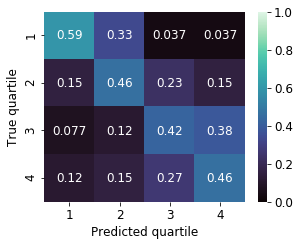

F1 results 0.4857142857142857


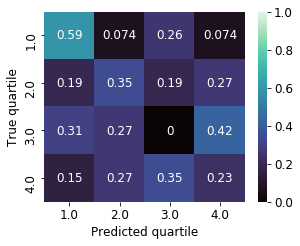

F1 shuffled results 0.29523809523809524


In [14]:
"""
PLOT RESULTS
"""

# -- Confusion Matrix
labels = np.array(mat[var])

# Results on original model
plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 3.5])
hmap = sns.color_palette("mako", as_cmap=True)
data = decoding_result.loc[(decoding_result['matrix'] == 0) & (decoding_result['shuffle'] == 0)]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels.astype(int)), xticklabels=np.unique(labels.astype(int)), 
    cmap= hmap, vmin=0, vmax=1) 
plt.xlabel('Predicted quartile')
plt.ylabel('True quartile')
plt.show()
print('F1 results', data['f1'].mean())

# Results from shuffled model
plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 3.5])
data = decoding_result.loc[(decoding_result['matrix'] == 0) & (decoding_result['shuffle'] == 1)]
sns.heatmap(data['confusion_matrix'].mean(), annot=True, 
    yticklabels=np.unique(labels), xticklabels=np.unique(labels), 
    cmap= hmap, vmin=0, vmax=1)
plt.xlabel('Predicted quartile')
plt.ylabel('True quartile')
plt.show()
print('F1 shuffled results',  data['f1'].mean())


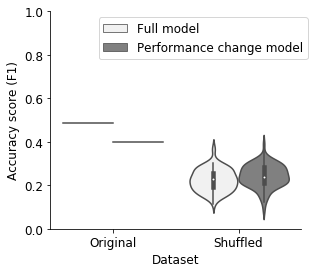

In [15]:
# -- F1 score per model, original and shuffled
data = decoding_result.copy()
data['f1'] = data['f1'].astype(float)
data.loc[data['matrix'] == 0, 'matrix'] = 'Full model'
data.loc[data['matrix'] == 1, 'matrix'] = 'Performance change model'
data = data.rename(columns={'matrix': 'Model'})

data.loc[data['shuffle'] >= 1, 'shuffle'] = 'Shuffled'
data.loc[data['shuffle'] == 0, 'shuffle'] = 'Original'
data = data.rename(columns={'shuffle': 'Dataset'})

plt.rc('font', size=12) 
plt.figure(figsize=[4.5, 4])
sns.violinplot(x='Dataset', y='f1', hue='Model', data=data, color='grey')
plt.ylim([0,1])
plt.ylabel('Accuracy score (F1)')
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine(top=True, right=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

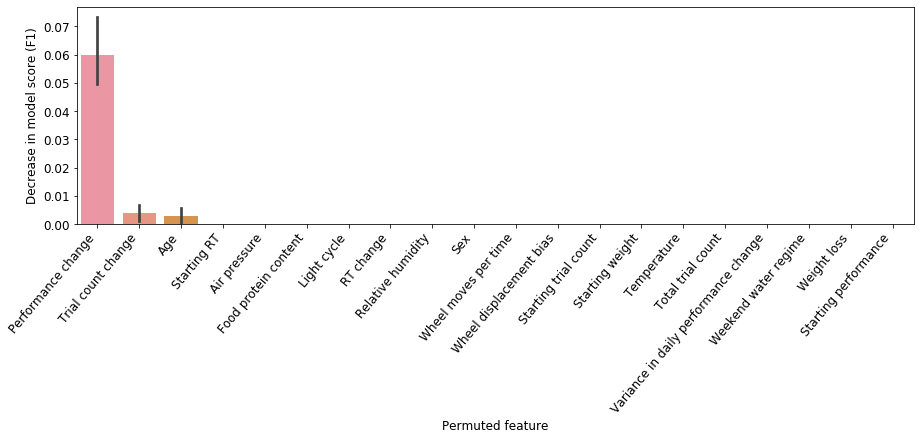

In [17]:
# -- Permutation tests for full model
f1_full_model = decoding_result.loc[(decoding_result['matrix']==0) & (decoding_result['shuffle']==0), 'f1'][0]
data = permutation_result.copy()
data['f1'] = data['f1'].astype(float)
data['f1'] = original_f1 - data['f1']
data = data.replace(['RT_delta1', 'RT_init', 'age_start', 'air_pressure_mb', 
    'delta_variance', 'disp_norm', 'moves_time',
    'perf_init', 'relative_humidity', 'sex', 
    'temperature_c', 'trials_delta1', 'trials_init', 'trials_sum', 
    'water_weight', 'weekend_water', 'weight_loss', 'light', 'food',
    'weight_start', 'perf_delta1'], ['RT change', 'Starting RT',
    'Age', 'Air pressure', 'Variance in daily performance change', 
    'Wheel displacement bias', 'Wheel moves per time',
    'Starting performance', 'Relative humidity', 'Sex', 'Temperature', 
    'Trial count change', 'Starting trial count', 'Total trial count',
    'Consumed water per body weight', 'Weekend water regime', 
    'Weight loss', 'Light cycle', 'Food protein content',
    'Starting weight', 'Performance change'])

plot_order = data.groupby('feature')['f1'].mean().sort_values(ascending=False).index.values
plt.figure(figsize=[15,4])
plt.rc('font', size=12) 
sns.barplot(x='feature', y='f1', data=data, 
    order=plot_order, orient='v', ci=95)
plt.xlabel('Permuted feature')
plt.ylabel('Decrease in model score (F1)')
ha = 'right'
plt.xticks(rotation=50, ha=ha)